In [1]:
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import numpy as np
import IPython.display as display
import torchvision.transforms as T

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

/home/jakub/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
image_path = 'dog.png'
image = Image.open(image_path).convert('RGB')
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 3, 363, 640])

In [5]:
with torch.no_grad():
    predictions = model(image_tensor)

In [6]:
predictions[0]

{'boxes': tensor([[295.1284,  46.7813, 467.2309, 305.1145],
         [217.6853,  58.0240, 427.8845, 314.8626],
         [233.1509,  76.7554, 325.3875, 161.5118],
         [ 82.3442,  48.7193, 487.1531, 331.4824],
         [261.4134,  36.5391, 468.2752, 304.8602],
         [234.9459,  77.7263, 325.9715, 159.5588],
         [236.3764,  75.7209, 326.7490, 157.7958],
         [320.2248,  99.0879, 425.4625, 302.2696]], device='cuda:0'),
 'labels': tensor([18, 18, 40, 18,  1, 34, 39, 20], device='cuda:0'),
 'scores': tensor([0.9835, 0.6501, 0.4431, 0.2319, 0.1448, 0.1010, 0.0703, 0.0536],
        device='cuda:0')}

In [7]:
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
idx_to_class = {}
for k, v in enumerate(coco_classes):
    idx_to_class[k] = v

In [8]:
def visualize(image, predictions, threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    ax = plt.gca()
    for idx in range(len(predictions["boxes"])):
        score = predictions["scores"][idx].item()
        if score >= threshold:
            box = predictions["boxes"][idx].cpu().numpy()
            label = predictions["labels"][idx].item()
            label = idx_to_class[label]
            
            # Draw bounding box
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"{label}, Score: {score:.2f}", color="red")
    
    plt.axis("off")
    plt.show()

In [9]:
def visualize_one(image, predictions, threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    ax = plt.gca()
    score = predictions['scores'][0].item()
    box = predictions["boxes"][0].cpu().numpy()
    label = predictions["labels"][0].item()
    label = idx_to_class[label]
    
    # Draw bounding box
    rect = patches.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(box[0], box[1], f"{label}, Score: {score:.2f}", color="red")
    
    plt.axis("off")
    plt.show()

In [10]:
def get_box(pred):
    box = pred["boxes"][0].cpu().numpy()
    label = pred["labels"][0].item()
    label = idx_to_class[label]

    return box[0], box[1], box[2], box[3], label

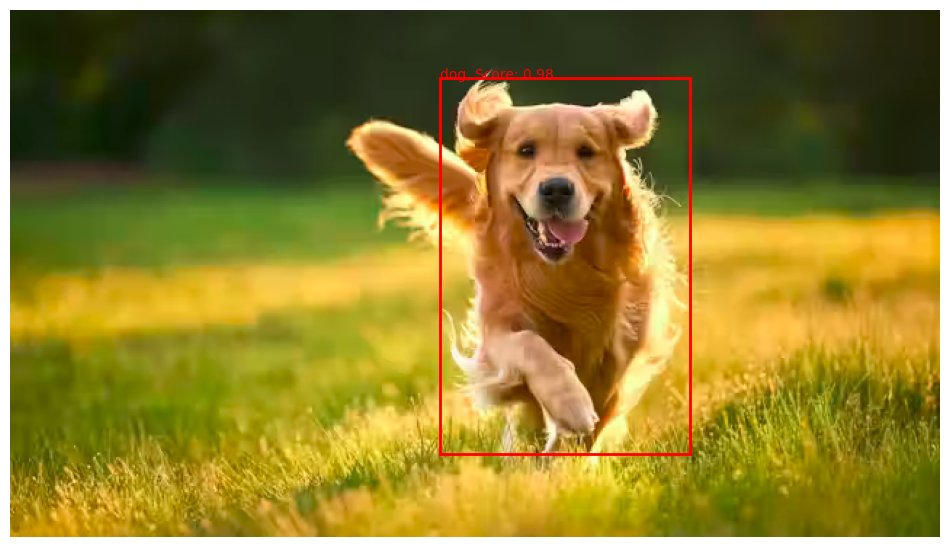

In [11]:
visualize_one(image, predictions[0])

In [11]:
import cv2
#def start_camera():
stream = cv2.VideoCapture(0)
stream.set(cv2.CAP_PROP_FPS, 2)
if not stream.isOpened():
    print('Camera not found :(')
    exit()

transform = T.ToTensor()
while(True):
    
    ret, BGR_frame = stream.read()
    frame = cv2.cvtColor(BGR_frame, cv2.COLOR_BGR2RGB)
    pil_frame = Image.fromarray(frame)
    frame_tensor = transform(frame).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(frame_tensor)

    x1, y1, x2, y2, label = get_box(prediction[0])
    
    if not ret:
        print('No more stream')
        break
        
    if cv2.waitKey(1) == ord('q'):
        break
        
    cv2.rectangle(BGR_frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    cv2.putText(BGR_frame, label, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    isolated_object_frame = BGR_frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.imshow('Isolated object', isolated_object_frame)
    cv2.imshow('Webcam', BGR_frame)

stream.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is not the object's thread (0x3b5285a0).
Cannot move to target thread (0x3af35c40)

QObject::moveToThread: Current thread (0x3af35c40) is n